<a href="https://colab.research.google.com/github/krumeto/sebra_data_playground/blob/main/SEBRA_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install dateparser

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import dateparser

import altair as alt

In [3]:
link_to_data = "https://data.egov.bg/resource/download/zip/ba444b96-6ec3-4be7-8981-92bc33d1a94b"

In [4]:
def data_load_sebra(link_to_data):
    data = pd.read_csv(link_to_data, compression = 'zip')
    data["REG_DATE"] = pd.to_datetime(data["REG_DATE"]).dt.normalize()
    data["SETTLEMENT_DATE"] = pd.to_datetime(data["SETTLEMENT_DATE"]).dt.normalize()
    return(data)

def lowercase_columns(dataf):
    dataf.columns = dataf.columns.str.lower()
    return(dataf)

def add_year(dataf):
    return(
        dataf.assign(reg_year = dataf['reg_date'].dt.year)
        )
    
def uppercase_all_object_cols(dataf):
    object_cols = dataf.select_dtypes("object").columns
    # For loop instead of apply for memory purposes
    for col in object_cols:
      dataf[col] = dataf[col].str.upper()
    return(dataf)


def pull_government_periods():
    """A function to pull periods of different governments and prepare the info in a format for left join"""

    # Data pull from wikipedia
    governments = pd.read_html("https://bg.wikipedia.org/wiki/%D0%9F%D1%80%D0%B0%D0%B2%D0%B8%D1%82%D0%B5%D0%BB%D1%81%D1%82%D0%B2%D0%B0_%D0%BD%D0%B0_%D0%91%D1%8A%D0%BB%D0%B3%D0%B0%D1%80%D0%B8%D1%8F",
                              match = "Република България"
                              )[0]

    # better column names              
    governments.columns = ["gov_nr", "government_alias", "government_pm", "government_start_dt", "government_end_dt", "n_days", "party/coalition"]

    # Get only post-communist goverments
    post_com_index = governments.loc[lambda d: d["gov_nr"] == "Република България (от 1990 г.)"].index
    governments = governments.iloc[lambda d: d.index > post_com_index[0]]

    # Convert dates using dateparser
    governments.government_start_dt = governments.government_start_dt.apply(dateparser.parse)

    # Weird if-else, as the last cell of the wikipedia article is usually empty, but occasionally - not
    if sum(governments.government_end_dt.isna()) > 0:
      governments.government_end_dt.iloc[:-1] = governments.government_end_dt.iloc[:-1].apply(dateparser.parse)
    else:
      governments.government_end_dt = governments.government_end_dt.apply(dateparser.parse)


    # extra cautious with dates, as we will be joining on them later
    governments.government_start_dt = pd.to_datetime(governments.government_start_dt).dt.normalize()
    governments.government_end_dt = pd.to_datetime(governments.government_end_dt).dt.normalize()


    # Get data in a long format
    # Potentially there is a much cleaner way, but data is small and this works
    long_gov_df = pd.DataFrame(columns = ["date", "government_alias", "government_pm", 'party/coalition'])

    # Iter over all rows
    for ix, row in governments.iterrows():
      interim_df = pd.DataFrame(columns = ["date", 'government_alias', 'government_pm', 'party/coalition'])
      # create a date_range starting from the day after a government starts until the day it ends
      try:
        date_period = pd.date_range(start = row["government_start_dt"] + pd.Timedelta(days=1), end = row["government_end_dt"])
      # except for the NA for the latest government
      except ValueError:
        date_period = pd.date_range(start = row["government_start_dt"] + pd.Timedelta(days=1), end = pd.Timestamp.today())
      interim_df["date"] = date_period
      interim_df["government_alias"] = row["government_alias"]
      interim_df["government_pm"] = row["government_pm"]
      interim_df['party/coalition'] = row['party/coalition']
      long_gov_df = pd.concat([long_gov_df, interim_df])

    long_gov_df["date"] = pd.to_datetime(long_gov_df["date"]).dt.normalize()
    return(long_gov_df)


def pull_bank_names_per_bic():
    """A function to pull bank names for a given bic"""

    bics_raw = pd.read_html("https://www.bnb.bg/RegistersAndServices/RSBAEAndBIC/index.htm")

    # clean the raw output
    bics = pd.DataFrame()

    for dataf in bics_raw:
      if dataf.shape[1] == 3 and dataf.shape[0] > 0:
        bics = pd.concat([bics, dataf])

    # keep the bics only
    bics = bics.dropna().iloc[:, [0,2]].reset_index(drop=True)
    bics.columns = ["bank_name", "bic"]

    # Expired and additional bics
    additional_banks_list = [('Българска народна банка', 'BNBGBGSF'),
    ('Българска народна банка', 'BNBGBGSD'),
    ('СИБАНК', 'BUIBBGSF'),
    ('УниКредит Булбанк АД', 'BFTBBGSF'),
    ('Сосиете Женерал Експрес Банк', 'TTBBBG22'),
    ('Unknown bank', 'ACBPGS2P'),
    ('МКБ Юнионбанк АД', 'CBUNBGSF'),
    ('ДЗИ Банк АД', 'REXIBGSF'),
    ('Корпоративна търговска банка АД', 'KORPBGSF'),
    ('Пиреус Банк България АД', 'PIRBBGSF'),
    ('ТИ БИ АЙ БАНК ЕАД', 'WEBKBGSF'),
    ('Алфа банк - клон България', 'CRBABGSF'),
    ('Креди Агрикол България', 'BINVBGSF'),
    ('SG Експресбанк AD', 'TTBB22'),
    ('ISBANK AG', 'ISBKBGSF'),
    ('Ейч Ви Би Банк БиохимАД', 'BACXBGSF')
    ]


    additional_banks_df = pd.DataFrame(additional_banks_list, columns = ["bank_name", "bic"])

    bics = pd.concat([bics, additional_banks_df]).reset_index(drop = True)
    bics = bics.loc[lambda d: d['bic'].str.len() <= 8].reset_index(drop = True)

    return(bics)

def get_a_report_per_iban(dataf, iban):
    
    all_rows = dataf.loc[lambda d: d["client_receiver_acc"] == iban]
    n_hashes = (all_rows["client_name_hash"].unique())
    n_client_receiver_name = (all_rows["client_receiver_name"].unique())
    flows = (all_rows.
             groupby(["primary_organization", "reg_year"])['amount'].
             agg(["sum", 'count']).
             sort_values('reg_year'))
    
    return([all_rows, n_hashes, n_client_receiver_name, flows])

## Data pull

In [5]:
data = (data_load_sebra(link_to_data).
        # Lowercase columns
        pipe(lowercase_columns).
        # Add year as a separate column
        pipe(add_year).
        # Add columns for government during the period
        # joining on settlement date gets more results than on reg_date
        merge(pull_government_periods(), 
              how ='left',
              left_on ='settlement_date',
              right_on = 'date').
        drop(columns = ['date']).
        # Add bank names
        merge(pull_bank_names_per_bic(),
              how = "left",
              left_on = "client_receiver_bic",
              right_on = "bic").
        drop(columns = ['bic']).
        pipe(uppercase_all_object_cols))


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [6]:
data.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3586569 entries, 0 to 3586568
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   settlement_date       3586569 non-null  datetime64[ns]
 1   client_receiver_name  3586569 non-null  object        
 2   client_receiver_acc   3586569 non-null  object        
 3   client_receiver_bic   3586569 non-null  object        
 4   fin_code              3586569 non-null  int64         
 5   amount                3586569 non-null  float64       
 6   currency              3586569 non-null  object        
 7   reason1               3459986 non-null  object        
 8   reason2               2626159 non-null  object        
 9   reg_date              3586569 non-null  datetime64[ns]
 10  reg_no                3586569 non-null  object        
 11  sebra_pay_code        3586569 non-null  int64         
 12  organization          3586569 non-null  ob

In [7]:
data.memory_usage(deep=True)

Index                    28692552
settlement_date          28692552
client_receiver_name    421915869
client_receiver_acc     283338951
client_receiver_bic     233126657
fin_code                 28692552
amount                   28692552
currency                215194140
reason1                 406202872
reason2                 268175751
reg_date                 28692552
reg_no                  232019451
sebra_pay_code           28692552
organization            453448592
primary_organization    463518178
primary_org_code         28692552
client_name_hash        433974849
reg_year                 28692552
government_alias        355401724
government_pm           467705026
party/coalition         425022480
bank_name               448850867
dtype: int64

In [8]:
data.sample(10)

,settlement_date,client_receiver_name,client_receiver_acc,client_receiver_bic,fin_code,amount,currency,reason1,reason2,reg_date,...,sebra_pay_code,organization,primary_organization,primary_org_code,client_name_hash,reg_year,government_alias,government_pm,party/coalition,bank_name
698993,2010-11-12,ТОПЛОФИКАЦИЯ,BG35SOMB91301037415503,SOMBBGSF,60051402,6195.84,BGN,ПАРНО ШИФЪР 314,1 27794/30.11.10,2010-10-12,...,10,ОС - ПЕРНИК,ВИСШ СЪДЕБЕН СЪВЕТ,6,DE13031E56C74506732A0AAA2C0793ACE2741CF4E5C518...,2010,БОРИСОВ 1,БОЙКО БОРИСОВ(РОД. 1959),ГЕРБ[3],ОБЩИНСКА БАНКА АД
2132999,2017-06-28,ЕООД Д-Р БОРЯНА ДРАГНЕВА,BG49STSA93000019305894,STSABGSF,560270008,5858.88,BGN,Д.N 270401/2017 390301,0517 0517900000001661806179,2017-06-27,...,40,РЗОК-ШУМЕН,НЗОК,56,D4C1157A8EE4F943D152023E128E8587B01C37140502C0...,2017,БОРИСОВ 3,БОЙКО БОРИСОВ(РОД. 1959),"ГЕРБ, ОБЕДИНЕНИ ПАТРИОТИ",БАНКА ДСК АД
3512931,2022-04-20,ОБЩИНА ИВАНОВО,BG06CECB979031F2318200,CECBBGSF,153000004,42029.44,BGN,ЛИЧНА ПОМОЩ,0322 03229ФС01 0346 010819,2022-04-19,...,60,АСП - ЦУ,МИНИСТЕРСТВО НА ТРУДА И СОЦИАЛНАТА ПОЛИТИКА,15,AE3F6709CCCBAE6375732705BFDF480CA8F5B7F0265638...,2022,К. ПЕТКОВ,КИРИЛ ПЕТКОВ(РОД. 1980),"ПП, БСП, ИТН, ДБ",ЦЕНТРАЛНА КООПЕРАТИВНА БАНКА АД
1160201,2013-03-27,ДСП ТЪРГОВИЩЕ,BG27BPBI79433198527700,BPBIBGSF,153009254,18868.59,BGN,ППЗЗД 420240,0213 02139,2013-03-19,...,40,265. РДСП ТЪРГОВИЩЕ,МИНИСТЕРСТВО НА ТРУДА И СОЦИАЛНАТА ПОЛИТИКА,15,D922D40EF41559FD9BE99D30B90BFA56450969A89E67CC...,2013,РАЙКОВ,МАРИН РАЙКОВ(РОД. 1960),СЛУЖЕБЕН; НЕЗАВИСИМИ,ЮРОБАНК БЪЛГАРИЯ АД
928232,2012-07-02,БАНКА ДСК 8001,BG26STSA93000094400701,STSABGSF,550090077,3743578.60,BGN,1210825210055 ПЕНСИИ 02.12,0212 0212 03.02.12,2012-06-02,...,50,ДОО-ПЕНСИИ - РУСО-ГАБРОВО,НОИ ? ДЪРЖАВНО ОБЩЕСТВЕНО ОСИГУРЯВА,55,BB16B453CA44C486E720F1A3D64C636A2BA9B4FA5DCDF4...,2012,БОРИСОВ 1,БОЙКО БОРИСОВ(РОД. 1959),ГЕРБ[3],БАНКА ДСК АД
1773188,2015-12-17,ФИЗИЧЕСКО ЛИЦЕ,BG21BPBI79381056747101,BPBIBGSF,1220093239,7343.79,BGN,M214-АЕП,NaN,2015-12-16,...,89,РАЗПЛ А-ИЯ-ДИРЕКТНИ-ПЛАЩАНИЯ-ЕЗФРСР,ДФ ЗЕМЕДЕЛИЕ-РАЗПЛАЩАТЕЛНА АГЕНЦИЯ,122,406C73C2D6F83CDD39240279464ED8A8922F23AD2E2A9D...,2015,БОРИСОВ 2,БОЙКО БОРИСОВ(РОД. 1959),"ГЕРБ, РЕФОРМАТОРСКИ БЛОК, АБВ",ЮРОБАНК БЪЛГАРИЯ АД
53732,2006-11-13,ТД НАП,BG32BUIB78378113700000,BUIBBGSF,221005457,6689.82,BGN,ДДС М.10.06,NaN,2006-09-11,...,18,350 РУГ- КЮСТЕНДИЛ,МИНИСТЕРСТВО НА ЗЕМЕДЕЛИЕТО И ГОРИТЕ,22,577C1CE536B0E5371F94A684B68DF159F8CFA732B396C1...,2006,СТАНИШЕВ,СЕРГЕЙ СТАНИШЕВ(РОД. 1966),"БСП, НДСВ, ДПС",СИБАНК
1753884,2015-11-27,БРАВО-СТРОЙ ООД,BG45UNCR75271063951014,UNCRBGSF,6663056669,45128.15,BGN,ДОГ. РД16-07-17 16 321 01525 9 0200,000082,2015-11-24,...,88,6605 КРИЧИМ,ЦЕНТРАЛЕН БЮДЖЕТ - БЕЗЛИХВЕНИ ЗАЕМИ,666,1AFC7753516AF306E433DF28D6D20E9A4A89E65B5D9374...,2015,БОРИСОВ 2,БОЙКО БОРИСОВ(РОД. 1959),"ГЕРБ, РЕФОРМАТОРСКИ БЛОК, АБВ",УНИКРЕДИТ БУЛБАНК АД
1520921,2014-11-27,ХИПОКРАТ АСИМП МЦ ЕООД,BG44FINV91501015814665,FINVBGSF,560160000,15905.99,BGN,Д.N 163667/2014 УД.1ДОК1014 1014,90000000044041114,2014-11-26,...,40,РЗОК-ПЛОВДИВ,НЗОК,56,A9575253826ECB43FC56167B4907772CB9DF7E93276D82...,2014,БОРИСОВ 2,БОЙКО БОРИСОВ(РОД. 1959),"ГЕРБ, РЕФОРМАТОРСКИ БЛОК, АБВ",ПЪРВА ИНВЕСТИЦИОННА БАНКА АД
698053,2010-09-12,ОБЩИНА ТУТРАКАН,BG06CECB97903147458500,CECBBGSF,4443770006,6464.00,BGN,ОБЩА ДОПЪЛВАЩА СУБСИДИЯ,NaN,2010-08-12,...,60,ТУТРАКАН - ОБЩА СУБСИДИЯ,ЦБ - СУБСИДИИ ЗА ОБЩИНИ,444,9088CE42D37D77E6F471428814248E084ACDBCB322A33E...,2010,БОРИСОВ 1,БОЙКО БОРИСОВ(РОД. 1959),ГЕРБ[3],ЦЕНТРАЛНА КООПЕРАТИВНА БАНКА АД


### Brief EDA

#### Dates differ by a day, but also by about a month, two or three months

Settlement date minus reg_date:

count    3586569.00
mean           5.11
std           58.28
min         -334.00
10%            1.00
25%            1.00
50%            1.00
75%           30.00
90%           31.00
max          359.00
dtype: float64
Most frequent delta between settlement date and reg_date:

1      1601977
31      318390
3       280297
30      270266
2       170394
0        99359
4        93987
92       92954
28       41288
61       39727
5        37595
91       31847
6        25507
122      19310
29       17279
7        15093
90       14776
123      11436
153       9693
89        9313
dtype: int64


<AxesSubplot:title={'center':'Settlement date minus Reg date in days'}, ylabel='Frequency'>

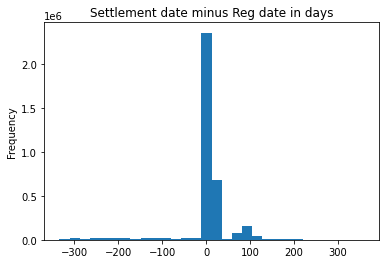

In [9]:
settlement_date_minus_reg_date = (data.settlement_date - data.reg_date).dt.days

print("Settlement date minus reg_date:\n\n", 
      (settlement_date_minus_reg_date.
      describe(percentiles = [.10, .25, .5, .75, .90]).
      round(2)), 
      sep = "")


print("Most frequent delta between settlement date and reg_date:\n\n", 
      (settlement_date_minus_reg_date.value_counts().nlargest(20)), 
      sep = "")

((settlement_date_minus_reg_date.
      plot.hist(bins =30, title = "Settlement date minus Reg date in days")))


In [10]:
# Only transfers in BGN
## TODO think of some inflation adjustments
data.currency.unique()

array(['BGN'], dtype=object)

### Biggest overall flows (not very telling)

Better to aggregate by primary_org_code and then get the main name. See different names for НОИ.

In [11]:
overall_flows = data.groupby(["primary_organization", "primary_org_code", "client_receiver_name"], as_index = False)['amount'].agg(["sum", 'count']).reset_index()

overall_flows.nlargest(20, columns = ['sum']).style.format({"sum": "{:,.0f}"})

,primary_organization,primary_org_code,client_receiver_name,sum,count
268461,НОИ - ДОО,55,БАНКА ДСК АД ЦУ ГР.СОФИЯ,"23,668,491,106",1559
271544,НОИ - ДОО,55,ОББ АД КЛ. ЦЕНТРАЛЕН,"6,501,729,692",1408
327308,ЦБ - СУБСИДИИ ЗА ОБЩИНИ,444,СТОЛИЧНА ОБЩИНА,"6,001,380,848",826
159856,МИНИСТЕРСТВО НА РЕГИОНАЛНОТО РАЗВИТ,21,МРРБ,"5,191,383,748",1697
301575,ПРЕДПРИЯТИЕ ЗА УПРАВЛЕНИЕ НА ДЕЙНОСТИТЕ ПО ОПАЗВАНЕ НА ОКОЛНАТА СРЕДА,119,"ФОНД ""СЕЛС""","5,156,011,246",76
311600,"ФОНД ""СИГУРНОСТ НА ЕЛЕКТРОЕНЕРГИЙНАТА СИСТЕМА""",124,НЕК ЕАД,"4,995,101,853",81
272269,НОИ - ДОО,55,ПЪРВА ИНВЕСТИЦИОННА БАНКА,"4,869,167,924",2640
273653,НОИ - ДОО,55,ТП СПС,"4,797,700,358",3153
274439,НОИ - ДОО,55,ЮРОБАНК БЪЛГАРИЯ АД,"4,444,238,403",1456
53272,ДФ ЗЕМЕДЕЛИЕ-РАЗПЛАЩАТЕЛНА АГЕНЦИЯ,122,ФИЗИЧЕСКО ЛИЦЕ,"4,361,584,058",296376


Excl. НОИ?



In [12]:
(overall_flows.loc[lambda d: d["primary_org_code"] != 55].
 nlargest(20, columns = ['sum']).
 style.format({"sum": "{:,.0f}"}))

,primary_organization,primary_org_code,client_receiver_name,sum,count
327308,ЦБ - СУБСИДИИ ЗА ОБЩИНИ,444,СТОЛИЧНА ОБЩИНА,"6,001,380,848",826
159856,МИНИСТЕРСТВО НА РЕГИОНАЛНОТО РАЗВИТ,21,МРРБ,"5,191,383,748",1697
301575,ПРЕДПРИЯТИЕ ЗА УПРАВЛЕНИЕ НА ДЕЙНОСТИТЕ ПО ОПАЗВАНЕ НА ОКОЛНАТА СРЕДА,119,"ФОНД ""СЕЛС""","5,156,011,246",76
311600,"ФОНД ""СИГУРНОСТ НА ЕЛЕКТРОЕНЕРГИЙНАТА СИСТЕМА""",124,НЕК ЕАД,"4,995,101,853",81
53272,ДФ ЗЕМЕДЕЛИЕ-РАЗПЛАЩАТЕЛНА АГЕНЦИЯ,122,ФИЗИЧЕСКО ЛИЦЕ,"4,361,584,058",296376
324012,ЦБ - СУБСИДИИ ЗА ОБЩИНИ,444,ОБЩИНА ПЛОВДИВ,"2,009,567,216",608
323642,ЦБ - СУБСИДИИ ЗА ОБЩИНИ,444,ОБЩИНА ВАРНА,"1,874,841,944",633
35168,"ДФ ""ЗЕМЕДЕЛИЕ""",122,ФИЗИЧЕСКО ЛИЦЕ,"1,764,410,206",108355
312131,"ФОНД ""СИГУРНОСТ НА ЕЛЕКТРОЕНЕРГИЙНАТА СИСТЕМА""",124,ФСЕЛС,"1,584,211,887",60
156451,МИНИСТЕРСТВО НА РЕГИОНАЛНОТО РАЗВИТ,21,АВТОМАГИСТРАЛИ ЕАД,"1,400,825,688",516


## Top individuals per amount transferred

Most of the top individual's seem to be just some organization using a personal name for a number of transfers.

In [13]:
(data.
 loc[(data["client_receiver_name"] == "ФИЗИЧЕСКО ЛИЦЕ")].
 groupby(["client_receiver_acc", "bank_name"])['amount'].
 agg(["sum", 'count']).
 sort_values('sum', ascending = False).
 head(20).
 style.format("{:,.0f}")
 )

,,sum,count
client_receiver_acc,bank_name,,
BG40BNBG96611000066123,БЪЛГАРСКА НАРОДНА БАНКА,"285,715,372","9,980"
BG95BPBI79421076516501,ЮРОБАНК БЪЛГАРИЯ АД,"262,899,263",19
BG52RZBB91553120008113,КЕЙ БИ СИ БАНК БЪЛГАРИЯ ЕАД,"57,932,168",98
BG26RZBB91553100055002,КЕЙ БИ СИ БАНК БЪЛГАРИЯ ЕАД,"44,503,471",136
BG86TTBB94001525796131,СОСИЕТЕ ЖЕНЕРАЛ ЕКСПРЕС БАНК,"24,315,169",255
BG27KORP92201000000100,КОРПОРАТИВНА ТЪРГОВСКА БАНКА АД,"16,489,738",9
BG94BPBI79421022439601,ЮРОБАНК БЪЛГАРИЯ АД,"14,583,000",1
BG28BUIN72201010650432,АЛИАНЦ БАНК БЪЛГАРИЯ АД,"13,409,529",48
BG34UNCR70001500193116,УНИКРЕДИТ БУЛБАНК АД,"12,558,646",168


In [14]:
# This one seems just a BNB IBAN
get_a_report_per_iban(data,"BG40BNBG96611000066123")

[        settlement_date             client_receiver_name  \
 0            2006-06-06          БЪЛГАРСКА НАРОДНА БАНКА   
 33           2006-07-06          БЪЛГАРСКА НАРОДНА БАНКА   
 345          2006-07-06          БЪЛГАРСКА НАРОДНА БАНКА   
 346          2006-07-06          БЪЛГАРСКА НАРОДНА БАНКА   
 347          2006-07-06          БЪЛГАРСКА НАРОДНА БАНКА   
 ...                 ...                              ...   
 3580248      2022-06-24      МИНИСТЕРСТВО НА ЗЕМЕДЕЛИЕТО   
 3580898      2022-06-24                             УАСГ   
 3581135      2022-06-27  М ВО НА ОБРАЗОВАНИЕТО И НАУКАТА   
 3583660      2022-06-27       БЪЛГАРСКО НАЦИОНАЛНО РАДИО   
 3583839      2022-06-27             МГУ "СВ.ИВАН РИЛСКИ"   
 
             client_receiver_acc client_receiver_bic    fin_code     amount  \
 0        BG40BNBG96611000066123            BNBGBGSD   100000004   10000.00   
 33       BG40BNBG96611000066123            BNBGBGSD   100000004   10000.00   
 345      BG40BNBG96611000066

In [15]:
# This one seems just БДЖ
get_a_report_per_iban(data,"BG95BPBI79421076516501")

[        settlement_date         client_receiver_name     client_receiver_acc  \
 1126368      2013-02-14               ФИЗИЧЕСКО ЛИЦЕ  BG95BPBI79421076516501   
 1126369      2013-02-14               ФИЗИЧЕСКО ЛИЦЕ  BG95BPBI79421076516501   
 1154496      2013-03-13               ФИЗИЧЕСКО ЛИЦЕ  BG95BPBI79421076516501   
 1170181      2013-10-04               ФИЗИЧЕСКО ЛИЦЕ  BG95BPBI79421076516501   
 1189348      2013-10-05               ФИЗИЧЕСКО ЛИЦЕ  BG95BPBI79421076516501   
 ...                 ...                          ...                     ...   
 2404239      2018-07-08  БДЖ ПЪТНИЧЕСКИ ПРЕВОЗИ ЕООД  BG95BPBI79421076516501   
 2422858      2018-11-09  БДЖ ПЪТНИЧЕСКИ ПРЕВОЗИ ЕООД  BG95BPBI79421076516501   
 2439940      2018-12-10  БДЖ ПЪТНИЧЕСКИ ПРЕВОЗИ ЕООД  BG95BPBI79421076516501   
 2457670      2018-12-11  БДЖ ПЪТНИЧЕСКИ ПРЕВОЗИ ЕООД  BG95BPBI79421076516501   
 2470524      2018-11-30  БДЖ ПЪТНИЧЕСКИ ПРЕВОЗИ ЕООД  BG95BPBI79421076516501   
 
         client_receiver_b

In [16]:
# This is just Rakitovo's municipality
get_a_report_per_iban(data, "BG52RZBB91553120008113")

[        settlement_date client_receiver_name     client_receiver_acc  \
 2582835      2019-04-19         ОБЩИНА ТРОЯН  BG52RZBB91553120008113   
 2584642      2019-04-19       ФИЗИЧЕСКО ЛИЦЕ  BG52RZBB91553120008113   
 2591031      2019-04-24       ФИЗИЧЕСКО ЛИЦЕ  BG52RZBB91553120008113   
 2606842      2019-07-05       ФИЗИЧЕСКО ЛИЦЕ  BG52RZBB91553120008113   
 2608373      2019-09-05       ФИЗИЧЕСКО ЛИЦЕ  BG52RZBB91553120008113   
 ...                 ...                  ...                     ...   
 3561640      2022-06-06       ФИЗИЧЕСКО ЛИЦЕ  BG52RZBB91553120008113   
 3566693      2022-06-15         ОБЩИНА ТРОЯН  BG52RZBB91553120008113   
 3577206      2022-06-20         ОБЩИНА ТРОЯН  BG52RZBB91553120008113   
 3577900      2022-06-21         ОБЩИНА ТРОЯН  BG52RZBB91553120008113   
 3583777      2022-06-27       ФИЗИЧЕСКО ЛИЦЕ  BG52RZBB91553120008113   
 
         client_receiver_bic    fin_code      amount currency  \
 2582835            RZBBBGSF   153000004    27782.92     

In [17]:
# This is just Troyan's municipality
get_a_report_per_iban(data, "BG26RZBB91553100055002")

[        settlement_date client_receiver_name     client_receiver_acc  \
 2200601      2017-03-11       ФИЗИЧЕСКО ЛИЦЕ  BG26RZBB91553100055002   
 2202794      2017-07-11       ФИЗИЧЕСКО ЛИЦЕ  BG26RZBB91553100055002   
 2207136      2017-11-15       ФИЗИЧЕСКО ЛИЦЕ  BG26RZBB91553100055002   
 2209880      2017-11-22      ОБЩИНА РАКИТОВО  BG26RZBB91553100055002   
 2212311      2017-11-27       ФИЗИЧЕСКО ЛИЦЕ  BG26RZBB91553100055002   
 ...                 ...                  ...                     ...   
 3542892      2022-05-19      ОБЩИНА РАКИТОВО  BG26RZBB91553100055002   
 3564694      2022-10-06       ФИЗИЧЕСКО ЛИЦЕ  BG26RZBB91553100055002   
 3566684      2022-06-15      ОБЩИНА РАКИТОВО  BG26RZBB91553100055002   
 3577210      2022-06-20      ОБЩИНА РАКИТОВО  BG26RZBB91553100055002   
 3580839      2022-06-24       ФИЗИЧЕСКО ЛИЦЕ  BG26RZBB91553100055002   
 
         client_receiver_bic    fin_code     amount currency  \
 2200601            RZBBBGSF  4442490000  460000.00      B

## Time series per organization

In [25]:
data.columns

Index(['settlement_date', 'client_receiver_name', 'client_receiver_acc',
       'client_receiver_bic', 'fin_code', 'amount', 'currency', 'reason1',
       'reason2', 'reg_date', 'reg_no', 'sebra_pay_code', 'organization',
       'primary_organization', 'primary_org_code', 'client_name_hash',
       'reg_year', 'government_alias', 'government_pm', 'party/coalition',
       'bank_name'],
      dtype='object')

In [70]:
orgs_and_codes = data.loc[:, ['primary_organization', 'primary_org_code']].drop_duplicates(subset = ['primary_org_code'], keep = "last", )

organizations_monthly = (data.
                         groupby('primary_org_code').
                         resample('MS', on = 'settlement_date')["amount"].
                         sum().
                         reset_index(drop = False).
                         merge(orgs_and_codes,
                               how = 'left',
                               on = 'primary_org_code'
                               )
                         )

In [75]:
orgs_and_codes.loc[lambda d:d['primary_organization'].str.contains("ОБЩ")]

,primary_organization,primary_org_code
508128,ДЪРЖАВНА АГЕНЦИЯ ЗА ИТ И СЪОБЩЕНИЯ,50
3440137,ЦЕНТРАЛЕН БЮДЖЕТ - ДРУГИ ТРАНСФЕРИ ЗА ОБЩИНИ,488
3584218,КОМИСИЯ ЗА РЕГУЛИРАНЕ НА СЪОБЩЕНИЯТ,43
3586512,ЦБ - СУБСИДИИ ЗА ОБЩИНИ,444


In [66]:
organizations_monthly.sample(30)

,primary_org_code,settlement_date,amount,primary_organization
408,3,2006-01-01,1.619637e+05,МИНИСТЕРСКИ СЪВЕТ
16995,853,2019-01-01,1.673324e+05,НАЦИОНАЛНА ХУДОЖЕСТВЕНА АКАДЕМИЯ
8458,45,2015-07-01,2.308818e+05,КОМИСИЯ ЗА ЕНЕРГ.И ВОДНО РЕГУЛИРАНЕ
13394,745,2011-07-01,7.377759e+06,УЧИТЕЛСКИ ПЕНСИОНЕН ФОНД
3666,20,2016-03-01,3.228609e+06,МИНИСТЕРСТВО НА ИКОНОМИКАТА
8502,45,2016-10-01,1.500000e+04,ДЪРЖ. К-ИЯ ПО ЕНЕРГ. И ВОДНО РЕГУЛ
8988,47,2011-09-01,3.338056e+05,КОМИСИЯ ЗА ФИНАНСОВ НАДЗОР
2543,17,2018-10-01,4.011179e+07,МИНИСТЕРСТВО НА ОБРАЗОВАНИЕТО И НАУКАТА
1732,14,2014-12-01,1.954674e+07,МИНИСТЕРСТВО НА ПРАВОСЪДИЕТО
12603,488,2020-03-01,0.000000e+00,ЦЕНТРАЛЕН БЮДЖЕТ - ДРУГИ ТРАНСФЕРИ ЗА ОБЩИНИ


In [76]:
def plot_organization_timeseries(dataf, groupby_col = 'primary_organization', time_col = 'settlement_date'):
    selection = alt.selection_multi(fields=[groupby_col], bind='legend')

    final_chart = alt.Chart(dataf).mark_line(point=alt.OverlayMarkDef()).encode(
        x= time_col,
        y='amount',
        color=alt.Color(groupby_col, scale=alt.Scale(scheme='tableau20')),
        strokeDash=groupby_col,
        tooltip = [groupby_col, time_col, 'amount'],
        opacity=alt.condition(selection, alt.value(1), alt.value(0.2))
    ).configure_legend(labelLimit= 0).add_selection(selection).properties(
        width=800,
        height=300
    ).interactive()

    return(final_chart)

In [73]:
(organizations_monthly.
 loc[lambda d:d['primary_organization'].str.contains("МИНИСТЕРСТВО")].
 pipe(plot_organization_timeseries)) 

alt.Chart(...)

In [72]:
(organizations_monthly.
 loc[lambda d:d['primary_organization'].str.contains("УНИВЕРСИТЕТ|УНСС|СУ КЛИМЕНТ ОХРИДСКИ|АКАДЕМИЯ")].
 pipe(plot_organization_timeseries)) 

alt.Chart(...)

In [48]:
selection = alt.selection_multi(fields=['primary_organization'], bind='legend')

alt.Chart(organizations_monthly.loc[lambda d:d['primary_organization'].str.contains("УНИВЕРСИТЕТ|УНСС")]).mark_line(point=alt.OverlayMarkDef()).encode(
    x='settlement_date',
    y='amount',
    color='primary_organization',
    strokeDash='primary_organization',
    tooltip = ['primary_organization', 'settlement_date', 'amount'],
    opacity=alt.condition(selection, alt.value(1), alt.value(0.2))
).configure_legend(labelLimit= 0).add_selection(selection).properties(
    width=800,
    height=300
).interactive()

alt.Chart(...)

<AxesSubplot:xlabel='settlement_date'>

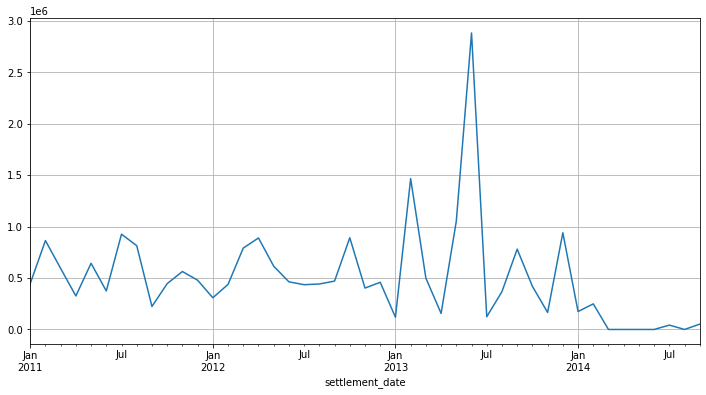

In [34]:
organizations_monthly.loc[lambda d:d['primary_organization'] == "АВИООТРЯД 28"].set_index("settlement_date").amount.plot(grid = True, figsize = (12,6))

In [42]:
organizations_monthly

,primary_organization,settlement_date,amount
0,АВИООТРЯД 28,2011-01-01,445705.56
1,АВИООТРЯД 28,2011-02-01,865071.13
2,АВИООТРЯД 28,2011-03-01,593993.08
3,АВИООТРЯД 28,2011-04-01,325900.99
4,АВИООТРЯД 28,2011-05-01,643642.31
...,...,...,...
16047,"ЮГОЗАПАДЕН УНИВЕРСИТЕТ ""НЕОФИТ РИЛСКИ"" - БЛАГО...",2022-07-01,427730.66
16048,"ЮГОЗАПАДЕН УНИВЕРСИТЕТ ""НЕОФИТ РИЛСКИ"" - БЛАГО...",2022-08-01,75579.89
16049,"ЮГОЗАПАДЕН УНИВЕРСИТЕТ ""НЕОФИТ РИЛСКИ"" - БЛАГО...",2022-09-01,65116.74
16050,"ЮГОЗАПАДЕН УНИВЕРСИТЕТ ""НЕОФИТ РИЛСКИ"" - БЛАГО...",2022-10-01,304191.00


## Some work on vectorizing the transfer reasons

In [18]:
# !pip install whatlies[all]

In [19]:
# from sklearn.pipeline import make_pipeline
# from sklearn.decomposition import TruncatedSVD

# from whatlies.language import BytePairLanguage
# from whatlies.transformers import Umap

In [20]:
# lang_bp1 = BytePairLanguage("bg", vs=200000, dim=300)

In [21]:
# comments_combined = list(data.reason1.fillna(" ") + " " + data.reason2.fillna(" "))

In [22]:
# comments_vectorized = lang_bp1.fit_transform(comments_combined)

In [23]:
# km = MiniBatchKMeans(
#         n_clusters=k_means_clusters,
#         init="k-means++",
#         n_init=1,
#         init_size=1000,
#         batch_size=1000
#     )

# clust_pipe = make_pipeline(lang_bp1, km)

In [24]:
#clusters_reason1 = clust_pipe.fit_predict(list(data.reason1.fillna(" ")))